# Capstone - Pneumonia Detection Challenge - Modeling using Mask RCNN

### Here are the insights from Mask R CNN model:

Results

Import Necessary Packages

In [1]:
%tensorflow_version 1.x
import tensorflow
tensorflow.__version__

TensorFlow 1.x selected.


'1.15.2'

In [2]:
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug

     |████████████████████████████████| 1.9MB 18.6MB/s 


In [3]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import glob

import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline
import cv2

import keras
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.applications import DenseNet201
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ROOT_DIR = '/content/drive/MyDrive/RSNA_PneumoniaDetectionChallenge'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

In [6]:
print(ROOT_DIR)
print(MODEL_DIR)
os.chdir(ROOT_DIR)

/content/drive/MyDrive/RSNA_PneumoniaDetectionChallenge
/content/drive/MyDrive/RSNA_PneumoniaDetectionChallenge/logs


In [ ]:
os.chdir(ROOT_DIR)
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 11.75 MiB/s, done.
Resolving deltas: 100% (562/562), done.
Checking out files: 100% (76/76), done.
zip_safe flag not set; analyzing archive contents...


In [ ]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')


Some setup functions and classes for Mask-RCNN

    dicom_fps is a list of the dicom image path and filenames
    image_annotions is a dictionary of the annotations keyed by the filenames
    parsing the dataset returns a list of the image filenames and the annotations dictionary



In [ ]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

In [ ]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    RPN_ANCHOR_SCALES = (32, 64)
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
    STEPS_PER_EPOCH = 100
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

In [ ]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [ ]:
# training dataset
anns = pd.read_csv(os.path.join(ROOT_DIR, 'stage_1_train_labels.csv'))
anns.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [ ]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [ ]:
print(len(image_fps))
image_fps[0]

26684


'/content/drive/MyDrive/RSNA_PneumoniaDetectionChallenge/stage_1_train_images/d4874b9e-a350-4143-9dea-8f3282605f77.dcm'

In [ ]:
print(len(image_annotations))
val = image_annotations.items()
value_iterator = iter(val)
print(next(value_iterator))

26684
('/content/drive/MyDrive/RSNA_PneumoniaDetectionChallenge/stage_1_train_images/d4874b9e-a350-4143-9dea-8f3282605f77.dcm', [patientId    d4874b9e-a350-4143-9dea-8f3282605f77
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 23596, dtype: object])


In [ ]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [ ]:
# show dicom fields 
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.18277.1517874409.599503
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.18277.1517874409.599503
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

Split the data into training and validation datasets

In [ ]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
image_fps_list = list(image_fps) 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

24015 2669


Create and prepare the training dataset using the DetectorDataset class.

In [ ]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [ ]:
dataset_train

In [ ]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

Display a random image with bounding boxes

(1024, 1024, 3)
/content/drive/MyDrive/RSNA_PneumoniaDetectionChallenge/stage_1_train_images/e17bacff-85d3-47b3-b2cb-2a3e123a6912.dcm
[1]


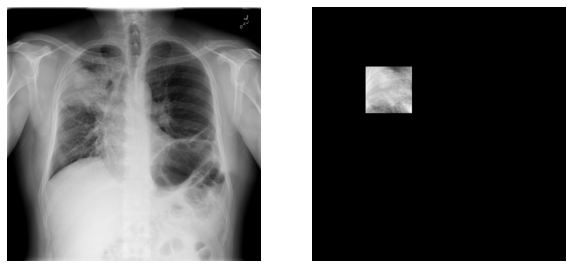

In [ ]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


Image Augmentation. Try finetuning some variables to custom values

In [ ]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])


Training the model

    dataset_train and dataset_val are derived from DetectorDataset
    DetectorDataset loads images from image filenames and masks from the annotation data
    model is Mask-RCNN



In [ ]:
# Changes done in Model.py
# Change tensor_metrics to metrics (line 2199)
#!python setup.py -q install

In [ ]:
NUM_EPOCHS = 5

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all'
            #augmentation=augmentation
            )


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/RSNA_PneumoniaDetectionChallenge/logs/pneumonia20210219T1022/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
re

In [ ]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/drive/MyDrive/RSNA_PneumoniaDetectionChallenge/logs/pneumonia20210219T1022/mask_rcnn_pneumonia_0005.h5


In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/MyDrive/RSNA_PneumoniaDetectionChallenge/logs/pneumonia20210219T1022/mask_rcnn_pneumonia_0005.h5
Re-starting from epoch 5
Loading weights from  /content/drive/MyDrive/RSNA_PneumoniaDetectionChallenge/logs/pneumonia20210219T1022/mask_rcnn_pneumonia_0005.h5
Re-starting from epoch 5


In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.100, .904, .204))
    return colors

### Compare predicted box to the expected value






*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



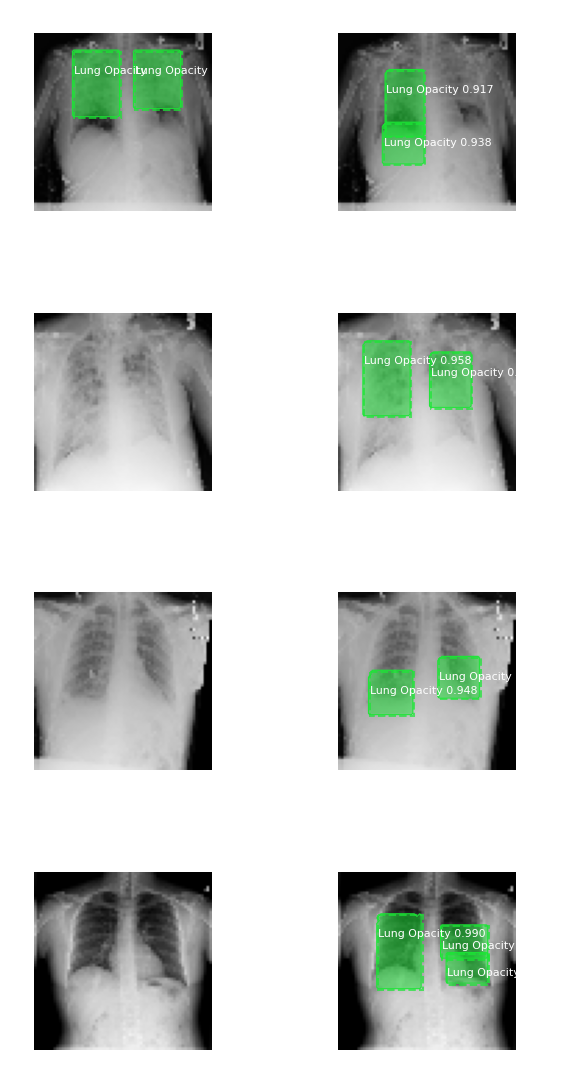

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

### Predictions on the Validation Set

In [ ]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='output_94pc.csv', min_conf=0.94): 
    
    # assume square image
    
    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps): 
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        
        r = results[0]
        #print(r)

        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        
        flags = 0

        if len(r['rois']) == 0: 
            out_str += ",Not,0"                    
        else: 
            num_instances = len(r['rois'])
            out_str += ','
            for i in range(num_instances): 
                if r['scores'][i] > min_conf:
                    flags  = 1
                    
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str
                
            if flags == 0:
                  out_str += "Not,0"
            else:
                  out_str += ",1"

        #print(out_str)
        file.write(out_str+"\n")

In [ ]:
# Predict on the validation set
output_file = 'output_94pc.csv'
predict(image_fps_val, filepath=output_file)

100%|██████████| 2669/2669 [06:03<00:00,  7.33it/s]


In [ ]:
output = pd.read_csv(output_file, names = ['patientId', 'PredString', 'Prediction'])
print(output.shape)
print(output.dtypes)
output.head()

(2669, 3)
patientId     object
PredString    object
Prediction     int64
dtype: object


,patientId,PredString,Prediction
0,b0b3ee88-fc81-4a0a-acdb-d8c030fac137,0.96 607 398 284 268,1
1,742365a8-d9a5-41e4-b8a3-24a03a894f9f,0.96 257 272 224 350,1
2,c609093d-f0c1-4391-b318-43897454914f,0.98 265 450 189 1740.97 633 438 238 268,1
3,f8529eb0-34f1-4ea5-8c72-30fcb80eb33e,Not,0
4,bc8619aa-4d19-43d1-87a1-31b6f49a9942,0.94 545 406 277 268,1


In [ ]:
trains = pd.read_csv('train_labels.csv')

In [ ]:
dataval = pd.DataFrame(trains.loc[trains.patientId.isin(output.patientId), ['patientId', 'Target']])
print(dataval.shape, dataval.dtypes)
dataval.head()

(3020, 2) patientId    object
Target        int64
dtype: object


,patientId,Target
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
39,01a4059c-22f7-4f51-8a27-50aff0b3aeb3,0
43,01a7353d-25bb-4ff8-916b-f50dd541dccf,1
44,01a7353d-25bb-4ff8-916b-f50dd541dccf,1
48,01b56434-4dd9-4994-bcc5-0b70a36e415a,0


In [ ]:
dataval.drop_duplicates(keep='first',inplace=True)
print(dataval.shape)
dataval.to_csv('dataval.csv')
dataval.head()

(2669, 2)


,patientId,Target
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
39,01a4059c-22f7-4f51-8a27-50aff0b3aeb3,0
43,01a7353d-25bb-4ff8-916b-f50dd541dccf,1
48,01b56434-4dd9-4994-bcc5-0b70a36e415a,0
71,01ef1712-90a6-4946-ad86-fc76b0cf2d3b,0


In [ ]:
df_merge_col = pd.merge(dataval, output, on='patientId')
df_merge_col.shape

(2669, 4)

In [ ]:
df_merge_col.head()

,patientId,Target,PredString,Prediction
0,00322d4d-1c29-4943-afc9-b6754be640eb,0,0.99 148 303 276 3900.94 562 203 308 281,1
1,01a4059c-22f7-4f51-8a27-50aff0b3aeb3,0,0.99 242 453 216 3040.98 634 292 215 3420.96 2...,1
2,01a7353d-25bb-4ff8-916b-f50dd541dccf,1,Not,0
3,01b56434-4dd9-4994-bcc5-0b70a36e415a,0,0.99 630 327 231 4240.98 256 416 248 221,1
4,01ef1712-90a6-4946-ad86-fc76b0cf2d3b,0,0.99 149 357 281 3930.99 577 474 230 183,1


In [ ]:
df_merge.to_csv('df_merge_col.csv')

In [ ]:
print(df_merge_col.Prediction.value_counts())
print(df_merge_col.Target.value_counts())

1    2146
0     523
Name: Prediction, dtype: int64
0    2082
1     587
Name: Target, dtype: int64


In [ ]:
trueVal = []
trueVal = df_merge_col.Target.astype('int')
print(len(trueVal))
predVal = []
predVal = df_merge_col.Prediction.astype('int')
print(len(predVal))

2669
2669


In [ ]:
cm_maskrcnn = confusion_matrix(y_true=trueVal, y_pred=predVal)
print(cm_maskrcnn)

[[ 368 1714]
 [ 155  432]]


In [ ]:
print(classification_report(trueVal, predVal))

              precision    recall  f1-score   support

           0       0.70      0.18      0.28      2082
           1       0.20      0.74      0.32       587

    accuracy                           0.30      2669
   macro avg       0.45      0.46      0.30      2669
weighted avg       0.59      0.30      0.29      2669



In [ ]:
print("Accuracy using Mask RCNN on Validation set: ", round(accuracy_score(trueVal, predVal)*100,2))

Accuracy using Mask RCNN on Validation set:  29.97


### Predictions on the Train Set

In [ ]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='output.csv', min_conf=0.80): 
    
    # assume square image
    
    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps): 
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        
        r = results[0]
        #print(r)

        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        
        flags = 0

        if len(r['rois']) == 0: 
            out_str += ",Not,0"                    
        else: 
            num_instances = len(r['rois'])
            out_str += ','
            for i in range(num_instances): 
                if r['scores'][i] > min_conf:
                    flags  = 1
                    
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str
                
            if flags == 0:
                  out_str += "Not,0"
            else:
                  out_str += ",1"

        #print(out_str)
        file.write(out_str+"\n")

In [ ]:
# Predict on the validation set
output_file = 'output_train.csv'
predict(image_fps_train[:5000], filepath=output_file)

Streaming output truncated to the last 5000 lines.

 44%|████▍     | 2212/5000 [03:32<04:36, 10.08it/s]

 44%|████▍     | 2214/5000 [03:32<04:32, 10.23it/s]

 44%|████▍     | 2216/5000 [03:33<04:35, 10.12it/s]

 44%|████▍     | 2218/5000 [03:33<04:39,  9.94it/s]

 44%|████▍     | 2220/5000 [03:33<04:44,  9.78it/s]

 44%|████▍     | 2221/5000 [03:33<05:01,  9.22it/s]

 44%|████▍     | 2222/5000 [03:33<05:10,  8.96it/s]

 44%|████▍     | 2223/5000 [03:33<05:08,  9.01it/s]

 44%|████▍     | 2224/5000 [03:34<05:07,  9.02it/s]

 44%|████▍     | 2225/5000 [03:34<05:19,  8.67it/s]

 45%|████▍     | 2226/5000 [03:34<05:09,  8.96it/s]

 45%|████▍     | 2227/5000 [03:34<05:02,  9.18it/s]

 45%|████▍     | 2229/5000 [03:34<04:45,  9.71it/s]

 45%|████▍     | 2230/5000 [03:34<04:58,  9.29it/s]

 45%|████▍     | 2231/5000 [03:34<05:08,  8.97it/s]

 45%|████▍     | 2232/5000 [03:34<05:02,  9.16it/s]

 45%|████▍     | 2233/5000 [03:35<05:07,  9.01it/s]

 45%|████▍     | 2234/5000 [03:35<05:08,  8.98i

In [ ]:
output_train = pd.read_csv(output_file, names = ['patientId', 'PredString', 'Prediction'])
print(output_train.shape)
print(output_train.dtypes)
output_train.head(12)

(5000, 3)
patientId     object
PredString    object
Prediction     int64
dtype: object


,patientId,PredString,Prediction
0,525353ce-858a-47b5-aadb-3e25229f2d95,Not,0
1,ccaf24c4-e66d-4556-91f4-05c6f02c93f3,Not,0
2,f626cd28-748a-4b1c-8388-8dffa22bac5a,Not,0
3,72290038-af8f-4ebc-ae08-1cbb558ada40,Not,0
4,9f085bf1-c475-4535-aa1d-331bc8c421d5,Not,0
5,3c83072d-97ca-47d6-9d55-ec9f1f23c166,0.98 666 370 235 2450.98 233 323 231 221,1
6,b6dccc84-8b90-4d44-bcf0-12d038c09df4,Not,0
7,5313d411-d611-4c8a-af40-0f075d6d96f6,Not,0
8,bf02491f-2614-420e-b8c1-8779dbf5624f,0.99 216 404 217 2050.98 603 422 209 178,1
9,713190d9-5ef2-4867-9756-fc214e4969ea,Not,0


In [ ]:
trains = pd.read_csv('train_labels.csv')
trains.head()

,patientId,x,y,width,height,path,Age,Gender,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,stage2_train_images/0004cfab-14fd-4e49-80ba-63...,51,F,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,stage2_train_images/00313ee0-9eaa-42f4-b0ab-c1...,48,F,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,stage2_train_images/00322d4d-1c29-4943-afc9-b6...,19,M,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,stage2_train_images/003d8fa0-6bf1-40ed-b54c-ac...,28,M,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,stage2_train_images/00436515-870c-4b36-a041-de...,32,F,1


In [ ]:
dataval_train = pd.DataFrame(trains.loc[trains.patientId.isin(output_train.patientId), ['patientId', 'Target']])
dataval_train.head()

,patientId,Target
12,009eb222-eabc-4150-8121-d5a6d06b8ebf,0
13,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,0
18,00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b,0
22,0100515c-5204-4f31-98e0-f35e4b00004a,1
26,011d6f51-b732-4d45-a84d-90477325ef2d,0


In [ ]:
dataval_train.shape
keras.metrics.accuracy()

(5675, 2)

In [ ]:
dataval_train = dataval_train.astype('str')
dataval_train.head()
dataval_train.drop_duplicates(keep=False,inplace=True)
print(dataval_train.shape)
dataval_train.head()

(4353, 2)


,patientId,Target
12,009eb222-eabc-4150-8121-d5a6d06b8ebf,0
13,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,0
18,00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b,0
22,0100515c-5204-4f31-98e0-f35e4b00004a,1
26,011d6f51-b732-4d45-a84d-90477325ef2d,0


In [ ]:
df_merge_col_train = pd.merge(output_train, dataval_train, on='patientId')

In [ ]:
print(df_merge_col_train.shape)
df_merge_col_train.head()

(4353, 4)


,patientId,PredString,Prediction,Target
0,525353ce-858a-47b5-aadb-3e25229f2d95,Not,0,0
1,ccaf24c4-e66d-4556-91f4-05c6f02c93f3,Not,0,0
2,f626cd28-748a-4b1c-8388-8dffa22bac5a,Not,0,0
3,9f085bf1-c475-4535-aa1d-331bc8c421d5,Not,0,0
4,3c83072d-97ca-47d6-9d55-ec9f1f23c166,0.98 666 370 235 2450.98 233 323 231 221,1,0


In [ ]:
df_merge_col_train.Prediction.value_counts()

0    2929
1    1424
Name: Prediction, dtype: int64

In [ ]:
df_merge_col_train.Target.value_counts()

0    3839
1     514
Name: Target, dtype: int64

In [ ]:
trueVal_train = []
trueVal_train = df_merge_col_train.Target.astype('int')
len(trueVal_train)

4353

In [ ]:
predVal_train = []
predVal_train = df_merge_col_train.Prediction.astype('int')
len(predVal_train)

4353

In [ ]:
cm_maskrcnn_train = confusion_matrix(y_true=trueVal_train, y_pred=predVal_train)
print(cm_maskrcnn_train)

[[2558 1281]
 [ 371  143]]


In [ ]:
print(classification_report(trueVal_train, predVal_train))

              precision    recall  f1-score   support

           0       0.87      0.67      0.76      3839
           1       0.10      0.28      0.15       514

    accuracy                           0.62      4353
   macro avg       0.49      0.47      0.45      4353
weighted avg       0.78      0.62      0.68      4353



In [ ]:
print("Accuracy using Mask RCNN on Train set: ", round(accuracy_score(trueVal_train, predVal_train)*100,2))

Accuracy using Mask RCNN on Train set:  62.05


Creating Submission file and finding the score

In [ ]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

In [ ]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='PneumoniaDetection_Submission.csv', min_conf=0.94): 
    
    # assume square image
    
    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps): 
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        r = results[0]

        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
            out_str += ","
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str

        file.write(out_str+"\n")

In [ ]:
# predict only the first 3000 entries
sample_submission_fp = 'PneumoniaDetection_Submission_.94pc.csv'
predict(test_image_fps, filepath=sample_submission_fp)

100%|██████████| 3000/3000 [04:06<00:00, 12.19it/s]


Score on Kaggle based on this submissions file: 0.03125